# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install --upgrade pandas

    100% |████████████████████████████████| 9.5MB 2.9MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.2MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 26.7MB/s ta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: pandas 0.23.3
    Uninstalling pandas-0.23.3:
      Successfully uninstalled pandas-0.23.3


In [2]:
import pandas as pd
import numpy as np
import math
import json
import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, f1_score
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Transformations to the transcript df

In [3]:
#A function which takes value and return True if the value is float otherwise it returns False 
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [4]:
#Making a new column which contains the offer id if the line is related to offer, otherwise it is kept empty 
#Retrive the first value from the dict in the value column
transcript["id"] = transcript["value"].apply(lambda x: list(x.values())[0])
#apply the is_float function, if it is False then it is kept, otherwise the cell become null
transcript["id"] = transcript["id"].apply(lambda x: x if is_float(x) == False else np.nan)

In [5]:
#Making a new column which contains the amount spent by the customer if the line is related to transaction,
#otherwise it is kept empty 
#Retrive the first value from the dict in the value column
transcript["amt"] = transcript["value"].apply(lambda x: list(x.values())[0])
transcript["amt"] = transcript["amt"].apply(lambda x: x if is_float(x) == True else np.nan)

In [6]:
#Making a new column which contains the reward receivied by the customer if the line is related to completed offer
transcript["reward"] = transcript["value"].apply(lambda x: list(x.values())[1] if len(x.values()) > 1 else np.nan)

# Transformations to the profile df

In [7]:
#filling empty cells in gender column with Unkown
profile["gender"] = profile["gender"].fillna("Unkown")

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


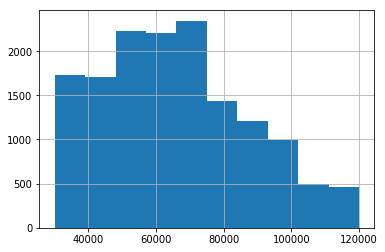

In [8]:
#printing stats summery of the income column
print(profile["income"].describe())

#plotting the income to choose a value to fill empty income cells with
profile["income"].hist()

In [9]:
#The 25th quantile seems reasonable to fill empty cells with
income_25_quantile = profile["income"].dropna().quantile(0.25)
profile["income"] = profile["income"].fillna(income_25_quantile)

In [10]:
#transform the became_member_on column into the type of datetime
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"], format='%Y%m%d')

In [11]:
#calcualting the number of days since the person became member with respect to the latest signing member
profile["member_since"] = (profile["became_member_on"].max() - profile["became_member_on"]).dt.days

In [12]:
#generating dummy columns for the gender column and dropping the gender column
gender = pd.get_dummies(profile["gender"],prefix="gender")
profile = pd.concat([profile,gender], axis=1).drop(columns = ["gender"])

# Transformations to the portfolio df

In [13]:
#Transforming the channel column (a column of lists) into dummy columns and dropping the channels columns
channel_dummies = pd.get_dummies(portfolio["channels"].explode(),prefix="channel")
channel_dummies = channel_dummies.groupby(channel_dummies.index).sum()

portfolio = pd.concat([portfolio,channel_dummies], axis=1).drop(columns = ["channels"])

In [14]:
#generating dummy columns for the offer_type column and dropping the offer_type column
offer_type = pd.get_dummies(portfolio["offer_type"],prefix="type")
portfolio = pd.concat([portfolio,offer_type], axis=1).drop(columns = ["offer_type"])

# The below block of code will iterate through all offers received by every person, the end goal is to create a new dataframe (offers_df) where each row contains the whole details for any offer sent to a person


# The below assumptions will be followed:
## 1- The same offer will not be sent in the validation period of an offer
## 2- Any offer which is not received will be ignored
## 3- Any offer which is completed beyond the validation period the completion event will be ignored
## 4- Any offer which is completed but not viewed will be considered as not viewed and not completed

In [ ]:
#Create a new df where each row is an offer received by a person, the row also contains all the offer data
offers_df = pd.DataFrame(columns=["person","offer_id","offer_view_amt","offer_received","offer_viewed","offer_completed","receive_time","view_time","complete_time","reward"])

#offers_df columns meaning:

#"person": person id
#"offer_id": offer id
#"offer_view_amt": The amount of views done by person on this offer
#"offer_received": 1 if the offer is received, otherwise 0
#"offer_viewed": 1 if the offer is viewd, otherwise 0
#"offer_completed": 1 if the offer is completed, otherwise 0
#"receive_time": offer receving time stamp
#"view_time": offer last view time stamp,
#"complete_time": offer completion time stamp,
#"reward":offer reward if completed   


#A list which will contains the retrived and cleaned data, it then will be the core of offers_df
lst = []


#iterate for each unique person in the transcript dataframe through the transcript dataframe 
for person in tqdm.tqdm(transcript["person"].unique()):
    
    #Create a temprary dataframe to grab the whole history for a person
    person_df = transcript[transcript["person"] == person].reset_index(drop = True).copy()
    
    #Create a temprorary dataframe for all offers received by a person
    recevied_offers_df = person_df[person_df["event"] == "offer received"].reset_index(drop = True).copy()
    
    #Calculate the maximum time for offer validity by fidning the offer duration of an offer in days 
    #then multiply the duration by 24 hours, then add it to offer receiving time  
    recevied_offers_df["maximum_time"] = recevied_offers_df["time"] + recevied_offers_df["id"].map(portfolio.set_index(["id"])["duration"])*24
    
    #Iterate through each received offer and grab it is data
    for row in range(recevied_offers_df.shape[0]):
        
        offer_rec_stamp = recevied_offers_df["time"].iloc[row] #offer receive time stamp
        offer_max_valid = recevied_offers_df["maximum_time"].iloc[row] #offer vaidation threshold time stamp
        offer_id = recevied_offers_df["id"].iloc[row] #offer id
        
        #Temporary df which include the events related to the recived offer id but only for the view and complete events
        #It also ensure that those events are after receving the offer and before the offer vaidation threshold
        view_complete_df = person_df[((person_df["time"] >= offer_rec_stamp) & (person_df["time"] <= offer_max_valid) & (person_df["event"] != "offer received") & (person_df["id"] == offer_id))].reset_index(drop=True).copy()
        
        #Temporary df which include the events related to the recived offer id but only for the receive event
        #It also ensure that those events are after receving the offer and before the offer vaidation threshold        
        receive_df = person_df[((person_df["time"] >= offer_rec_stamp) & (person_df["time"] <= offer_max_valid) & (person_df["event"] == "offer received") & (person_df["id"] == offer_id))].reset_index(drop=True).copy()
        
        #The amount an offer is viewed by a person
        offer_view_amt = view_complete_df.query("event == 'offer viewed'").shape[0]
        
        #The below is an IF-Else logic, which will decide the offer attributes based on the events in the view_complete_df
        
        if "offer completed" in view_complete_df.event.values and "offer viewed" in view_complete_df.event.values:
            offer_data_dict = {"person":person,
                                 "offer_id":offer_id,
                                 "offer_view_amt":offer_view_amt,
                                 "offer_received":1,
                                 "offer_viewed":1,
                                 "offer_completed":1,
                                 "receive_time":offer_rec_stamp,
                                 "view_time":view_complete_df.query("event == 'offer viewed'").time.max(),
                                 "complete_time":view_complete_df.query("event == 'offer completed'").time.iloc[0],
                                 "reward":view_complete_df.query("event == 'offer completed'").reward.iloc[0]}
            
            
            
            lst.append(list(offer_data_dict.values()))
        
        elif "offer viewed" in view_complete_df.event.values:
            offer_data_dict = {"person":person,
                                 "offer_id":offer_id,
                                 "offer_view_amt":offer_view_amt,
                                 "offer_received":1,
                                 "offer_viewed":1,
                                 "offer_completed":0,
                                 "receive_time":offer_rec_stamp,
                                 "view_time":view_complete_df.query("event == 'offer viewed'").time.max(),
                                 "complete_time":np.nan,
                                 "reward":np.nan}          
            
            
            lst.append(list(offer_data_dict.values()))
        
        else:
            offer_data_dict = {"person":person,
                                 "offer_id":offer_id,
                                 "offer_view_amt":offer_view_amt,
                                 "offer_received":1,
                                 "offer_viewed":0,
                                 "offer_completed":0,
                                 "receive_time":offer_rec_stamp,
                                 "view_time":np.nan,
                                 "complete_time":np.nan,
                                 "reward":np.nan}      
            lst.append(list(offer_data_dict.values()))
    

offers_df = pd.concat([offers_df,pd.DataFrame(lst, columns=offers_df.columns)], ignore_index=True)

# The below block is used to create a new dataframe (transactions_df), which will have all transactions, and link transactions with offers if there is a relation

In [ ]:
#Retriving all completed offers
completed_offers_df = offers_df[offers_df["offer_completed"] == 1].reset_index(drop=True).copy()

#Retriving all transactions from the transcript df
transactions_df = transcript[transcript["event"] == "transaction"].reset_index(drop=True).copy()

#Setting the below values to be iniatily 0 then it might change based on the logic in the loop below
transactions_df["offer_related"] = 0 # 1 if the transaction is related to an offer, otherwise 0
completed_offers_df["amount_spent"] = 0 #The amount of money spent which was motivated by the offer
completed_offers_df["transactions_count"] = 0 #The amount of transactions done which was motivated by the offer
transactions_df["offer_id"] = np.nan #offer id if there is a related offer to the transaction

transactions_df["reward"] = np.nan #The reward granted by the offer

#Iterate throgh each completed offer
for row in tqdm.tqdm(range(completed_offers_df.shape[0])):
    
    person = completed_offers_df["person"].iloc[row] #The offer sent to this person
    offer = completed_offers_df["offer_id"].iloc[row] #the offer id sent
    receive_time = completed_offers_df["receive_time"].iloc[row] #offer receive time stamp
    complete_time = completed_offers_df["complete_time"].iloc[row] #offer completion time stamp
    reward = completed_offers_df["reward"].iloc[row] # the reward received by the person
    
    #the transactions related to an offer are the ones which are between offer
    #receiving and completion times and it is for the same person 
    transactions = transactions_df.query(f"time >= {receive_time} and time <= {complete_time} and person == '{person}'").copy()
    
    #storing the amount of money spent motivated by the offer in the completed_offers_df 
    completed_offers_df.loc[row,"amount_spent"] = transactions.amt.sum()
    
    #storing the number of transactions motivated by the offer in the completed_offers_df 
    completed_offers_df.loc[row,"transactions_count"] = transactions.shape[0]
    
    #changing the transactions to be offer related or motivated
    transactions_df.loc[transactions.index,"offer_related"] = 1
    #find the related offer id 
    transactions_df.loc[transactions.index,"offer_id"] = offer
    #find the reward granted by offer completion
    transactions_df.loc[transactions.index,"reward"] = reward
    

In [ ]:
#merging the offers_df(without the completed offers) with completed_offers_df and saving it to pickle file
offers_df = pd.concat([offers_df[offers_df["offer_completed"] != 1].copy(),completed_offers_df], ignore_index=True)
offers_df.to_pickle("offers_df.pkl")

In [ ]:
#Saving the transactions into a pickle file after dropping the id and reward columns
transactions_df.drop(columns=["id","reward"],inplace=True)
transactions_df.to_pickle("transactions_df.pkl")

# Make a one dataframe which will be used as a training model, the model will aim to predict the activity of person if he received an offer 

In [15]:
#Reading the new dataframes which are saved in the previous step (to save time instead of iterating every time the code is run)
offers_df = pd.read_pickle("offers_df.pkl")
transactions_df = pd.read_pickle("transactions_df.pkl")

In [16]:
#retriving the person information using the person id from the profile dataframe
for col in ['gender_F','gender_M', 'gender_O', 'gender_Unkown', 'age', 'income', 'member_since']:
    offers_df[col] = offers_df["person"].map(profile.set_index(["id"])[col])

#retriving the offer information using the offer id from the portfolio dataframe
for col in ['reward', 'difficulty', 'duration', 'channel_email','channel_mobile', 'channel_social', 'channel_web', 'type_bogo','type_discount', 'type_informational']:
    offers_df[col] = offers_df["offer_id"].map(portfolio.set_index(["id"])[col])

In [17]:
#make a new column which convert receive_time into days
offers_df["receive_time_days"] = offers_df["receive_time"]/24

In [18]:
#The columns used as features to train the model
features_cols = ['gender_F','gender_M', 'gender_O', 'gender_Unkown', 'age', 
                 'income', 'member_since', 'difficulty', 'duration',
                'channel_email', 'channel_mobile', 'channel_social', 'channel_web',
               'type_bogo', 'type_discount', 'type_informational',
               'receive_time_days']
#target columns
target_cols = ['offer_viewed', 'offer_completed']

In [19]:
#training data will be all past days except the last day 
training_df = offers_df[offers_df["receive_time_days"] <= 23].reset_index(drop = True).copy()
#testing data fram will be the last day to measure the model preformance
test_df = offers_df[offers_df["receive_time_days"] > 23].reset_index(drop = True).copy()

In [27]:
#the algorithem used will be random forest calssifier
forest = RandomForestClassifier()

# the parameter grid which will be used to find the best hyperparameters for our model
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt','log2'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'criterion' :['gini', 'entropy'] #The criterion followed to measure the information gain
}

#grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, 
                        n_jobs=5, verbose=3,
                          cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0),
                          scoring=make_scorer(f1_score, average='weighted'))


grid_search.fit(training_df[features_cols], training_df[target_cols].astype(int))

Fitting 1 folds for each of 648 candidates, totalling 648 fits
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.7976989843103313, total=  18.0s
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.8051243489438732, total=  19.6s
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.8008040521750814, total=  36.5s
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1

[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  3.8min


[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.8127823382283277, total=  32.8s
[CV] criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=0.8129493070420434, total= 1.1min
[CV] criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.8140496834969048, total=  32.8s
[CV] criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.7985455745155798, total=  19.6s
[CV] criterion=gini, max_depth=N

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed: 16.8min


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.8172413445072155, total=  12.4s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, score=0.8182730647060076, total=  42.4s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.8175282830919625, total=  11.9s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.8179458998708153, total=  23.3s
[CV] criterion=gini, max_depth=10, max_feat

[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 39.8min


[CV] criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.807986876849098, total=  17.4s
[CV] criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, score=0.8079703069288925, total= 1.2min
[CV] criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.8076960426860716, total=  34.1s
[CV] criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_sp

[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed: 78.0min


[CV]  criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=0.8129087926158725, total=  19.5s
[CV] criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.8135650839713959, total=  18.9s
[CV] criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=0.811117224668154, total= 1.4min
[CV] criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.8141409040390148, total=  36.5s
[CV] criterion=entropy, max_

[Parallel(n_jobs=5)]: Done 648 out of 648 | elapsed: 105.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [28]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.8204194664441901


In [30]:
#The best parameters obtained by the grid search
best_params = {'criterion': 'gini', 
               'max_depth': 10, 
               'max_features': 'log2', 
               'min_samples_leaf': 1, 
               'min_samples_split': 2}

In [35]:
#instantiate the forest
forest = RandomForestClassifier(n_estimators=1000,n_jobs=-1, bootstrap=False,**best_params)

#Fitting the model using the best parameters obtained from the gridsearch
forest.fit(training_df[features_cols], training_df[target_cols].astype(int))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
#obtain the predections from the trained model for the test data
y_pred = forest.predict(test_df[features_cols])
#make a dataframe of the predections
y_pred_df = pd.DataFrame(y_pred, columns=target_cols)

In [38]:
#obtain the true values of the test data
y_true = test_df[target_cols].astype(float)

In [39]:
#classification report which compare the predection of viewing a received order against the true value
print(classification_report(y_true['offer_viewed'],y_pred_df['offer_viewed']))

             precision    recall  f1-score   support

        0.0       0.65      0.56      0.60      3033
        1.0       0.87      0.90      0.89      9732

avg / total       0.82      0.82      0.82     12765



In [41]:
#classification report which compare the predection of completing a viewed order against the true value
print(classification_report(y_true['offer_completed'],y_pred_df['offer_completed']))

             precision    recall  f1-score   support

        0.0       0.82      0.84      0.83      8149
        1.0       0.71      0.68      0.70      4616

avg / total       0.78      0.79      0.79     12765



In [60]:
#dataframe which showcase feature importance
pd.DataFrame(forest.feature_importances_,index=features_cols,columns=["importance"]).sort_values("importance",ascending= False)

,importance
channel_social,0.264724
difficulty,0.125966
member_since,0.110942
duration,0.101480
income,0.093697
type_informational,0.079002
age,0.061356
channel_mobile,0.043632
gender_Unkown,0.031599
type_discount,0.020053
